In [17]:
%matplotlib inline

# Mixture of Gaussians example


The idea is to show with an example how the Mixture of Gaussians (MG) method works. The codes are mainly adapted from [here](http://scikit-learn.org/stable/modules/mixture.html) and links therein. An MG model *assumes* that the probability distribution underlying our dataset can be described as a superposition of K Gaussian densities so that:

$$p(x) = \sum_{k=1}^K \pi_k \text{N}(x | \mu_k,\Sigma_k)$$

We will show with a simple example how the method can be applied using the sklearn module of python. First, we import the modules we will need:

In [18]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn import mixture
from sklearn.model_selection import StratifiedKFold
import itertools
from matplotlib.colors import LogNorm

**Data:** Let's imagine our dataset contains the recorded activity of two neurons whose firing rate depends on the state of the network. Therefore the firing rates corresponds to the *observed (visible) variables* (x) and the different states correspond to the *latent variables* that we do not observe.

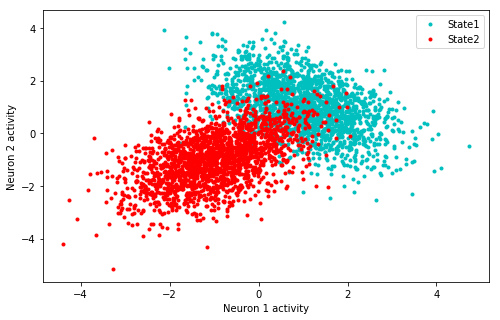

In [19]:
#HERE THE PARAMETERS TO PLAY WITH: 
#############
num_samples_per_st = 2000 # SIZE OF THE DATASET
distance_between_means = 1 # DISTANCE BETWEEN THE TWO ACTIVITIES
neurons_corr = 0.5 # NOISE CORRELATION BETWEEN THE TWO NEURONS
############

#DATA
# Activity of the two neurons under network state 1:
mean = (distance_between_means, distance_between_means)
cov = [[1, -neurons_corr], [-neurons_corr, 1]]
st1 = np.random.multivariate_normal(mean, cov, num_samples_per_st).T

# Activity of the two neurons under network state 2:
#(Note that for simplicity I have made the two distributions of activity symetric wrt to the origin 
# and so the activities associated with the second state are negative)
mean = (-distance_between_means, -distance_between_means) 
cov = [[1, neurons_corr], [neurons_corr, 1]]
st2 = np.random.multivariate_normal(mean, cov, num_samples_per_st).T

# Raw activity:
raw_activity = np.concatenate((st1,st2),axis=1)

#ground truth states
gt_sts = np.concatenate((np.zeros((num_samples_per_st,1)),np.ones((num_samples_per_st,1)))).reshape((2*num_samples_per_st,))


#PLOT THE DATA
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
ax.plot(raw_activity[0,gt_sts==0],raw_activity[1,gt_sts==0],'.c',label='State1')
ax.plot(raw_activity[0,gt_sts==1],raw_activity[1,gt_sts==1],'.r',label='State2')
ax.set_xlabel('Neuron 1 activity')
ax.set_ylabel('Neuron 2 activity')
ax.legend()

Fitting the data
--------

Fitting the dataset shown in the above figure only requires 2 lines. I have set the number of components to 2 and make no assumtpions about the covariance matrix. Later, we will explore different values of these parameters. [Here](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) more information about the GaussianMixture function.


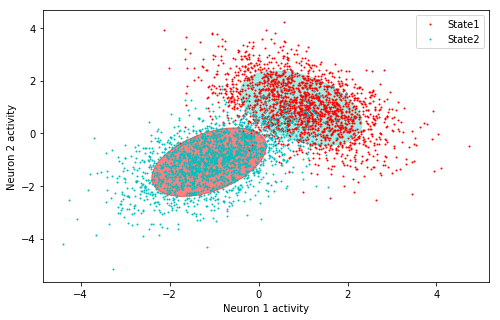

In [20]:
# Fit GMM
gmm = GaussianMixture(n_components=2, covariance_type="full", tol=0.001)
gmm = gmm.fit(X=raw_activity.T)

#PLOT THE FIT
# we first define a short function to plot ellipses
colors = ['red', 'turquoise','green','blue','black','yellow']
def make_ellipses(gmm, ax):
    for n in range(gmm.n_components):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        #np.linalg.eigh return the eigenvalues and eigenvectors of a Hermitian or symmetric matrix.
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])#this normalize the first eigen vector (probably not necessary)
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=colors[n])
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        
#now we plot        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
ax.plot(raw_activity[0,gt_sts==0],raw_activity[1,gt_sts==0],'.r',label='State1',markerSize=2)
ax.plot(raw_activity[0,gt_sts==1],raw_activity[1,gt_sts==1],'.c',label='State2',markerSize=2)
ax.set_xlabel('Neuron 1 activity')
ax.set_ylabel('Neuron 2 activity')
ax.legend()
make_ellipses(gmm,ax)


Model selection
-------------
We now evaluate how the *covariance_type* parameter affects the model performance. This parameter imposes **different constraints on the covariances matrices** and thus affects the capacity (flexibility) of the GM model. The *covariance_type* parameter can be:

- 'full' (each component has its own general covariance matrix),
- 'tied' (all components share the same general covariance matrix),
- 'diag' (each component has its own diagonal covariance matrix),
- 'spherical' (each component has its own single variance).

Although one would expect the full covariance to perform best in general, it is **prone to overfitting on small datasets and does not generalize well to held out test data**. 

We will also vary the **number of Gaussians components** as we would have to do in a real analysis in which we would not know the number of network states.

To evaluate the performance of each GM model we use the **Bayesian Information Criterion (BIC)**:

$$\text{BIC} = \ln(n)K-2\ln(p(x|\theta))$$

Where n is the number of samples, k is the number of parameters and $\ln(p(x|\theta))$ is the log-likelihood of the data given the parameters. As shown below, computing the BIC value with the sklearn is just one line.



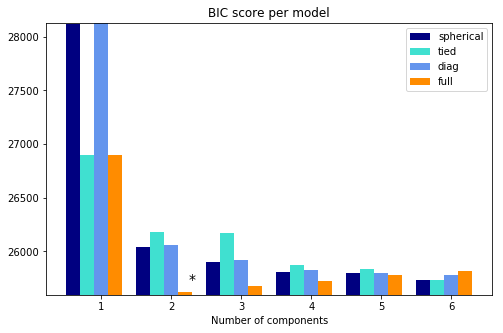

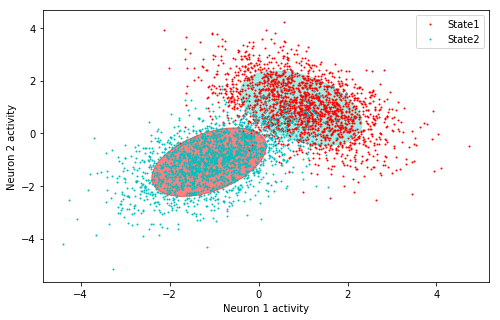

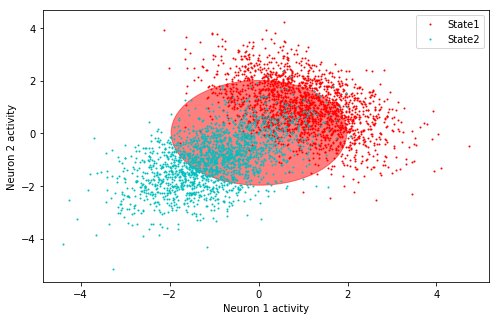

In [21]:
#COMPUTE THE BIC SCORE FOR ALL MODELS AND KEEP THE BEST OF THEM
lowest_bic = np.infty
highest_bic = -np.infty
bic = []
n_components_range = range(1, 7)#number of components from 1 to 6
cv_types = ['spherical', 'tied', 'diag', 'full']#types of covariances
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with the Expectation-Maximization algorithm
        #Define the model
        gmm_temp = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        #fit the data
        gmm_temp.fit(raw_activity.T)
        #With this line we obtain the BIC score
        bic.append(gmm_temp.bic(raw_activity.T))
        #if the performance is better in terms of BIC we keep the model as the best so far
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm_temp
        #if the performance is better in terms of BIC we keep the model as the best so far
        if bic[-1] >= highest_bic:
            highest_bic = bic[-1]
            worst_gmm = gmm_temp

bic = np.array(bic)

#PLOT THE BIC SCORES FOR ALL MODELS EVALUATED
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
bars = []

_,spl = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)


# PLOT THE BEST MODEL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
ax.plot(raw_activity[0,gt_sts==0],raw_activity[1,gt_sts==0],'.r',label='State1',markerSize=2)
ax.plot(raw_activity[0,gt_sts==1],raw_activity[1,gt_sts==1],'.c',label='State2',markerSize=2)
ax.set_xlabel('Neuron 1 activity')
ax.set_ylabel('Neuron 2 activity')
ax.legend()
make_ellipses(best_gmm,ax)

#AND THE WORST
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
ax.plot(raw_activity[0,gt_sts==0],raw_activity[1,gt_sts==0],'.r',label='State1',markerSize=2)
ax.plot(raw_activity[0,gt_sts==1],raw_activity[1,gt_sts==1],'.c',label='State2',markerSize=2)
ax.set_xlabel('Neuron 1 activity')
ax.set_ylabel('Neuron 2 activity')
ax.legend()
make_ellipses(worst_gmm,ax)

Density estimation
------

Once we have found the GM model that best fit the dataset, we have access to the (estimated) **probability density function** and can calculate the probability of any new sample x (i.e. any pair of rates at which the two neurons could fire). Obtaining the probability of a sample is (again) just one line. Here we do it for a whole grid and then use the *contour function* to plot the density function.

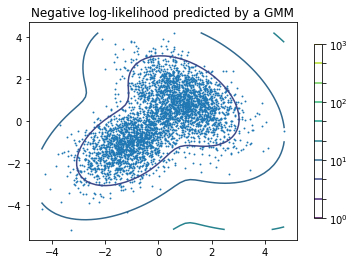

In [22]:
# display predicted scores by the model as a contour plot
x = np.linspace(np.min(raw_activity[0,:]), np.max(raw_activity[0,:]),50)
y = np.linspace(np.min(raw_activity[1,:]), np.max(raw_activity[1,:]),50)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

#here we get the log-probability of each value of the grid XX 
prob = -best_gmm.score_samples(XX)
prob = prob.reshape(X.shape)

#and plot it
CS = plt.contour(X, Y, prob, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(raw_activity[0, :], raw_activity[1, :], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()


Getting the posterior probabilities
----------

Maybe more interesting is the fact that we can compute **the probability of each network state given a recorded pair of firing rate activities**, i.e. the *posterior probability* $p(z|x)$ where z is the discrete random variable that represents the state of the network. Below, we color-code each sample in the dataset by the probabilities of corresponding to state 1 and to state2.

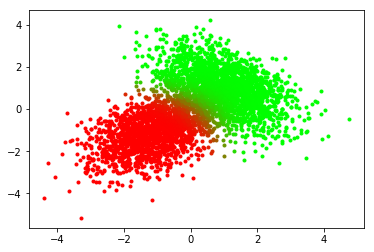

In [23]:
#get the posterior probabilities P(z|x) for all x in the dataset
P_z_x = best_gmm.predict_proba(raw_activity.T)
P_z_x /= np.max(P_z_x)

plt.figure()
for ind_p in range(raw_activity.shape[1]):
    plt.plot(raw_activity[0,ind_p],raw_activity[1,ind_p],'.',color=[1-P_z_x[ind_p,1], 1-P_z_x[ind_p,0], 0])
    

Furthermore, we can use our GM model for prediction and we can **compute the posterior probability for any new pair of recorded firing rates**. Below we compute the posterior probability for values in a grid, as we did for the log-likelihood. We then plot the posterior probability matrix associated with the grid for each state and the contour plot.

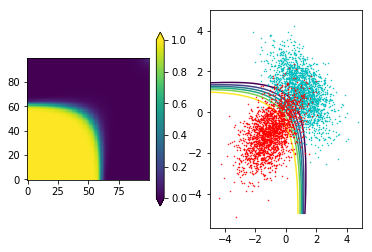

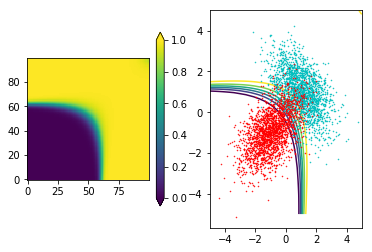

In [24]:
# display predicted scores by the model as a contour plot
limit = 5
x = np.linspace(-limit,limit,100)
y = np.linspace(-limit,limit,100)

X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

Z = best_gmm.predict_proba(XX)

for ind_z in range(best_gmm.n_components):
    Z_temp = Z[:,ind_z]
    Z_temp = Z_temp.reshape(X.shape)
    #Z_temp /= np.sum(Z_temp.flatten())
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(Z_temp,origin='lower')
    CB = plt.colorbar(shrink=0.8, extend='both')
    plt.subplot(1,2,2)
    plt.plot(raw_activity[0, gt_sts==0], raw_activity[1, gt_sts==0], '.c',markerSize=1)
    plt.plot(raw_activity[0, gt_sts==1], raw_activity[1, gt_sts==1], '.r',markerSize=1)
    CS = plt.contour(X, Y, Z_temp)#, norm=LogNorm(vmin=0.001, vmax=1000000.0),levels=np.logspace(0, 3, 100))
    plt.axis('equal')
    plt.axis('tight')


plt.show()
